<a href="https://colab.research.google.com/github/alyson-mei/ml_stuff/blob/beta/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.utils.data import random_split

from tqdm import tqdm
from IPython.display import clear_output

## Metrics

In [ ]:
def metric_batch(output, y, f):
    return f(torch.argmax(output, axis = 1), y)

In [ ]:
def accuracy(y_pred, y):

    if type(y) == list:
        y = torch.tensor(y)
    if type(y_pred) == list:
        y_pred = torch.tensor(y_pred)
    return float(torch.sum(y == y_pred) / len(y))

assert(accuracy([1,5,2,4,3,4], [2,5,2,3,3,1]) == 0.5)
assert(accuracy([1,2,3,4,5,6,7], [1,2,3,4,5,6,7]) == 1.0)
assert(accuracy([0,0,0,0], [1,1,1,1]) == 0.0)

def balanced_accuracy(y_pred, y, n_classes = 10):

    if type(y) == list:
        y = torch.tensor(y)
    if type(y_pred) == list:
        y_pred = torch.tensor(y_pred)
    s = 0.

    for c in range(n_classes):
        y_c = (y == c)
        y_pred_c = (y_pred == c)
        s += torch.sum(y_c * y_pred_c) / torch.sum(y_c)

    return float(s/n_classes)

assert np.isclose(balanced_accuracy([0, 0, 1], [0, 0, 1], 2), 1.0)
assert np.isclose(balanced_accuracy([0, 1], [1, 0], 2), 0.0)
assert np.isclose(balanced_accuracy([0, 0, 0], [0, 0, 1], 2), 0.5)
assert np.isclose(balanced_accuracy([1, 1, 2], [1, 0, 2], 3), 0.66666666666666)

In [ ]:
def precision(y_pred, y, n_classes = 10):

    if type(y) == list:
        y = torch.tensor(y)
    if type(y_pred) == list:
        y_pred = torch.tensor(y_pred)

    precisions = []
    for c in range(n_classes):
        y_c = (y == c)
        y_pred_c = (y_pred == c)
        precision = torch.sum(y_c * y_pred_c) / torch.sum(y_pred_c)
        precisions.append(precision.item())

    return torch.tensor(precisions)

def recall(y_pred, y, n_classes = 10):

    if type(y) == list:
        y = torch.tensor(y)
    if type(y_pred) == list:
        y_pred = torch.tensor(y_pred)

    recalls = []
    for c in range(n_classes):
        y_c = (y == c)
        y_pred_c = (y_pred == c)
        recall = torch.sum(y_c * y_pred_c) / torch.sum(y_c)
        recalls.append(recall.item())

    return torch.tensor(recalls)

def f_score(precisions, recalls):
    return 2. / (1/precisions + 1/recalls)


0.8857142857142856


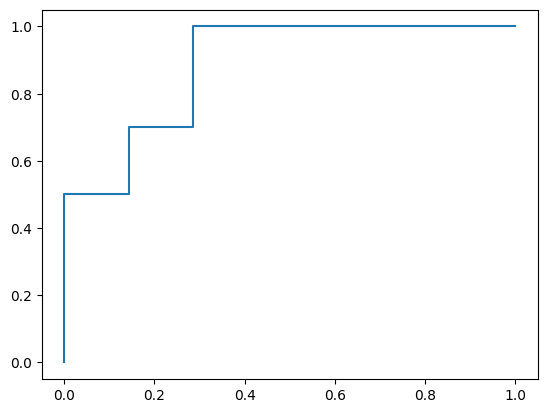

In [ ]:
def roc(y_probs, y):
    y_probs_argsort = np.argsort(y_probs)
    y = y[y_probs_argsort]
    n = len(y)
    fpr = np.array([0.] * (n + 1))
    tpr = np.array([0.] * (n + 1))
    pos = np.sum(y == 1)
    neg = n - pos

    true_pos = pos
    false_pos = neg
    roc_auc = 0.
    for i in range(n):
        tpr[n-i] = true_pos/pos
        fpr[n-i] = false_pos/neg
        if i > 0:
            delta = (tpr[n-i]) * (fpr[n-i]-fpr[n-i-1])
            roc_auc += (tpr[n-i]) * (fpr[n-i+1]-fpr[n-i])
        if y[i] == 1:
            true_pos -= 1
        else:
            false_pos -= 1

    print(roc_auc)
    plt.plot(fpr, tpr)
    plt.show()

y = np.array([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0])
y_probs = np.array([0.2, 0.4, 0.3, 0.17, 0.55, 0.8, 0.6, 0.5, 0.6, 0.6, 0.4, 0.14, 0.56, 0.87, 0.66, 0.78, 0.33])

roc(y_probs, y)

## Data + flatten

In [ ]:
N_CLASSES = 10
N_FEATS = 784
BATCH_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Flatten(object):
    def __call__(self, tensor):
        return tensor.flatten()

transform = transforms.Compose([
    transforms.ToTensor(),
    Flatten()
])

train_data = MNIST('/content', train=True, download=True, transform = transform)
test_data = MNIST('/content', train=False, transform = transform)
print(f"Train size: {train_data.__len__()}, test size: {test_data.__len__()}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 575kB/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.14MB/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw

Train size: 60000, test size: 10000


In [ ]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

## Train

In [ ]:
def train(model, train_loader, test_loader, optimizer, criterion, n_epochs = 10):

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(n_epochs):

        model.train()
        sum_loss_train = 0.
        sum_acc_train = 0.
        for input, target in tqdm(train_loader):
            input, target = input.to(DEVICE), target.to(DEVICE)
            output = model(input)

            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss_train += loss.item()
            sum_acc_train += metric_batch(output, target, f = accuracy)

        train_loss.append(sum_loss_train / len(train_loader))
        train_acc.append(sum_acc_train / len(train_loader))

        model.eval()
        sum_loss_test = 0.
        sum_acc_test = 0.
        with torch.no_grad():

            for input, target in tqdm(test_loader):

                input, target = input.to(DEVICE), target.to(DEVICE)
                output = model(input)

                loss = criterion(output, target)

                sum_loss_test += loss.item()
                sum_acc_test += metric_batch(output, target, f = accuracy)

        test_loss.append(sum_loss_test / len(test_loader))
        test_acc.append(sum_acc_test / len(test_loader))


        clear_output()
        print(f"epoch: {epoch + 1}")
        print(f"train loss: {train_loss[-1]}, train accuracy: {train_acc[-1]}")
        print(f"test loss: {test_loss[-1]}, test accuracy: {test_acc[-1]}")
        fig, axis = plt.subplots(1, 2, figsize=(12, 5))
        axis[0].plot(np.arange(1, epoch + 2), train_loss, label='train')
        axis[0].plot(np.arange(1, epoch + 2), test_loss, label='test')
        axis[1].plot(np.arange(1, epoch + 2), train_acc, label='train')
        axis[1].plot(np.arange(1, epoch + 2), test_acc, label='test')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()

    return train_acc, test_acc

In [ ]:
def eval(model, test_loader):

        model.eval()
        acc = 0.
        balanced_acc = 0.
        precisions = None
        recalls = None
        with torch.no_grad():

            for input, target in tqdm(test_loader):

                input, target = input.to(DEVICE), target.to(DEVICE)
                output = model(input)

                acc += metric_batch(output, target, f = accuracy)
                balanced_acc += metric_batch(output, target, f = balanced_accuracy)
                if precisions is None:
                    precisions = metric_batch(output, target, f = precision)
                else:
                    precisions += metric_batch(output, target, f = precision)
                if recalls is None:
                    recalls = metric_batch(output, target, f = recall)
                else:
                    recalls += metric_batch(output, target, f = recall)

        acc /= len(test_loader)
        balanced_acc /= len(test_loader)
        precisions /= len(test_loader)
        recalls /= len(test_loader)
        f_scores = f_score(precisions, recalls)

        return acc, balanced_acc, precisions, recalls, f_scores

## Logistic Regression



In [ ]:
class LogisticRegression(nn.Module):

    def __init__(self, in_dim = N_FEATS, out_dim = N_CLASSES):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, X):
        return self.fc(X)

In [ ]:
model = LogisticRegression().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
criterion = torch.nn.CrossEntropyLoss()

epoch: 10
train loss: 0.25166486050838077, train accuracy: 0.9300046741452992
test loss: 0.26709743694235116, test accuracy: 0.9259815705128205


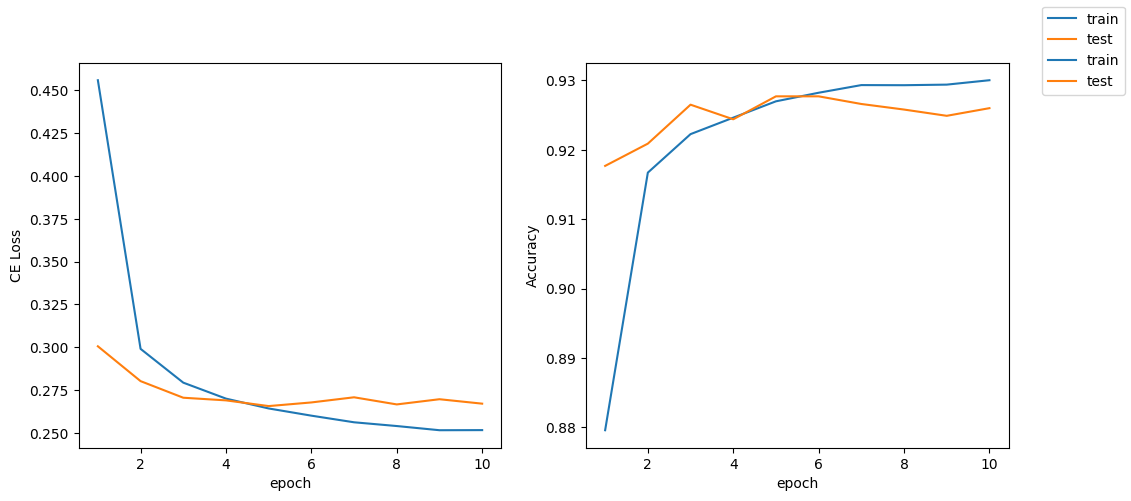

[0.8796073717948718, 0.9167000534188035, 0.9222422542735043, 0.9246127136752137, 0.9269664797008547, 0.9282017895299145, 0.9293035523504274, 0.9292868589743589, 0.9293703258547008, 0.9300046741452992] [0.9176682692307693, 0.9208733974358975, 0.9264823717948718, 0.9243790064102564, 0.9276842948717948, 0.9276842948717948, 0.926582532051282, 0.92578125, 0.9248798076923077, 0.9259815705128205]


In [ ]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion)
print(train_acc, test_acc)

In [ ]:
acc, balanced_acc, precisions, recalls, f_scores = eval(model, test_loader)
print(acc, balanced_acc, precisions, recalls, f_scores)

100%|██████████| 39/39 [00:01<00:00, 29.64it/s]

0.9259815705128205 0.9246287575134864 tensor([0.9544, 0.9567, 0.9222, 0.9092, 0.9316, 0.9096, 0.9346, 0.9388, 0.8835,
        0.9190]) tensor([0.9820, 0.9848, 0.8997, 0.9080, 0.9285, 0.8709, 0.9539, 0.9180, 0.8930,
        0.9074]) tensor([0.9680, 0.9706, 0.9108, 0.9086, 0.9301, 0.8898, 0.9442, 0.9283, 0.8882,
        0.9131])


## Logistic regression from sklearn + SVM

### Data

In [ ]:
_train_loader = DataLoader(train_data, batch_size = train_data.__len__(), shuffle = True)
_test_loader = DataLoader(test_data, batch_size = test_data.__len__(), shuffle = False)
_train = next(iter(_train_loader))
X_train, y_train = _train[0], _train[1]
_test = next(iter(_test_loader))
X_test, y_test = _test[0], _test[1]

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
lr_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
accuracy(lr_pred, y_test)

0.925599992275238

### SVC

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [ ]:
pred = model.predict(X_test)

In [ ]:
accuracy(pred, y_test)

0.979200005531311

## Fully connected NN

In [ ]:
class FCSimple(nn.Module):

    def __init__(self, in_dim = N_FEATS, out_dim = N_CLASSES, hidden_dim = 256):
        super(FCSimple, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, X):
        X = self.fc2(self.relu(self.fc1(X)))
        return X

In [ ]:
model = FCSimple().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

epoch: 10
train loss: 0.03623516012269717, train accuracy: 0.9901676014957265
test loss: 0.06928342798103888, test accuracy: 0.9788661858974359


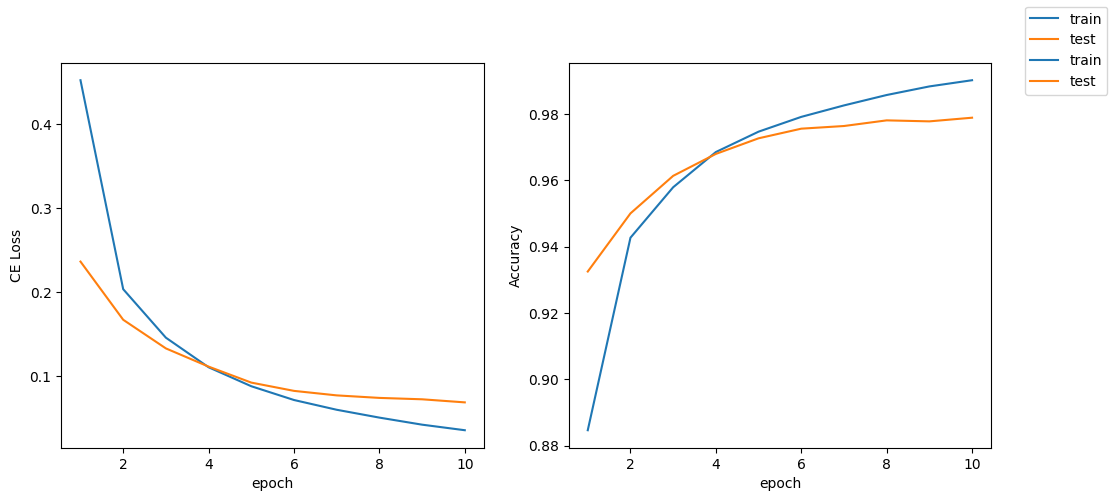

([0.8846487713675214,
  0.9426916399572649,
  0.9578993055555556,
  0.9685162927350427,
  0.9746594551282052,
  0.9791165865384616,
  0.9825721153846154,
  0.9857104700854701,
  0.9882979433760684,
  0.9901676014957265],
 [0.9324919871794872,
  0.950020032051282,
  0.9613381410256411,
  0.967948717948718,
  0.97265625,
  0.9755608974358975,
  0.9763621794871795,
  0.9780649038461539,
  0.9777644230769231,
  0.9788661858974359])

In [ ]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion)
print(train_acc, test_acc)

In [ ]:
eval(model, test_loader)

100%|██████████| 39/39 [00:01<00:00, 32.67it/s]


(0.9788661858974359,
 0.9788567974017217,
 tensor([0.9816, 0.9856, 0.9845, 0.9631, 0.9767, 0.9879, 0.9860, 0.9786, 0.9799,
         0.9675]),
 tensor([0.9871, 0.9913, 0.9703, 0.9897, 0.9866, 0.9730, 0.9743, 0.9769, 0.9673,
         0.9721]),
 tensor([0.9844, 0.9884, 0.9773, 0.9762, 0.9816, 0.9804, 0.9801, 0.9777, 0.9736,
         0.9698]))

In [ ]:
class FC2BNDropout(nn.Module):

    def __init__(self, in_dim = N_FEATS, out_dim = N_CLASSES, hidden_dim = 512, dropout = 0.5):
        super(FC2BNDropout, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(hidden_dim)

    def forward(self, X):
        X = self.bn(self.dropout(self.relu(self.fc1(X))))
        X = self.fc2(X)
        return X

In [ ]:
model = FC2BNDropout().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

epoch: 10
train loss: 0.051588614845377766, train accuracy: 0.9838741987179487
test loss: 0.057454501781672336, test accuracy: 0.9825721153846154


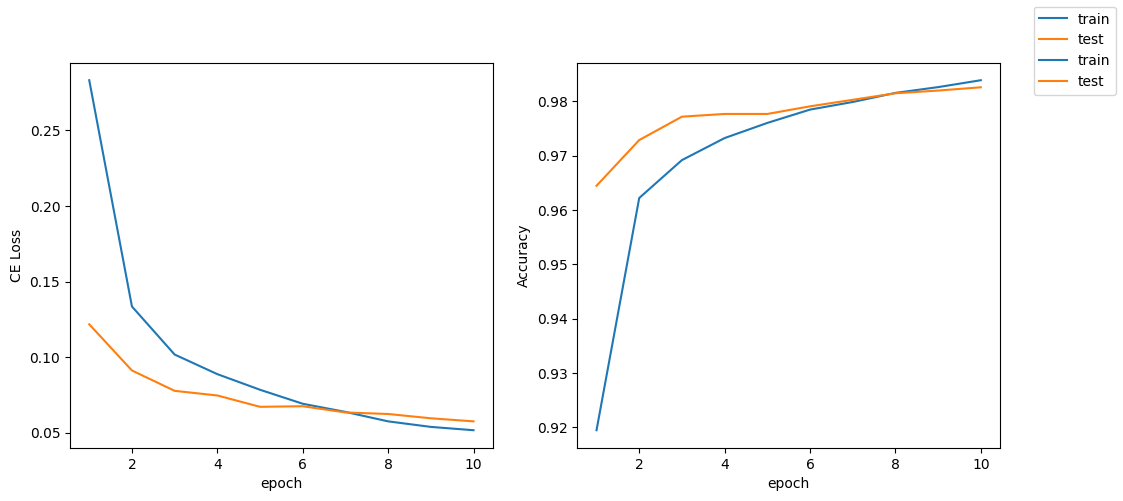

[0.9194377670940171, 0.9621895032051282, 0.9691673344017094, 0.9732238247863247, 0.9760116185897436, 0.9784655448717948, 0.9798677884615384, 0.9815371260683761, 0.9826055021367521, 0.9838741987179487] [0.9644431089743589, 0.9728565705128205, 0.9771634615384616, 0.9776642628205128, 0.9776642628205128, 0.9790665064102564, 0.9802684294871795, 0.9814703525641025, 0.9819711538461539, 0.9825721153846154]


In [ ]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion)
print(train_acc, test_acc)

In [ ]:
class FC3BNDropout(nn.Module):

    def __init__(self, in_dim = N_FEATS, out_dim = N_CLASSES, hidden_dim = 512, dropout = 0.5):
        super(FC3BNDropout, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, out_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        X = self.bn1(self.dropout(self.relu(self.fc1(X))))
        X = self.bn2(self.dropout(self.relu(self.fc2(X))))
        X = self.fc3(X)
        return X

In [ ]:
model = FC3BNDropout().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

epoch: 20
train loss: 0.050126558404543206, train accuracy: 0.9835403311965812
test loss: 0.05284714199642155, test accuracy: 0.9833733974358975


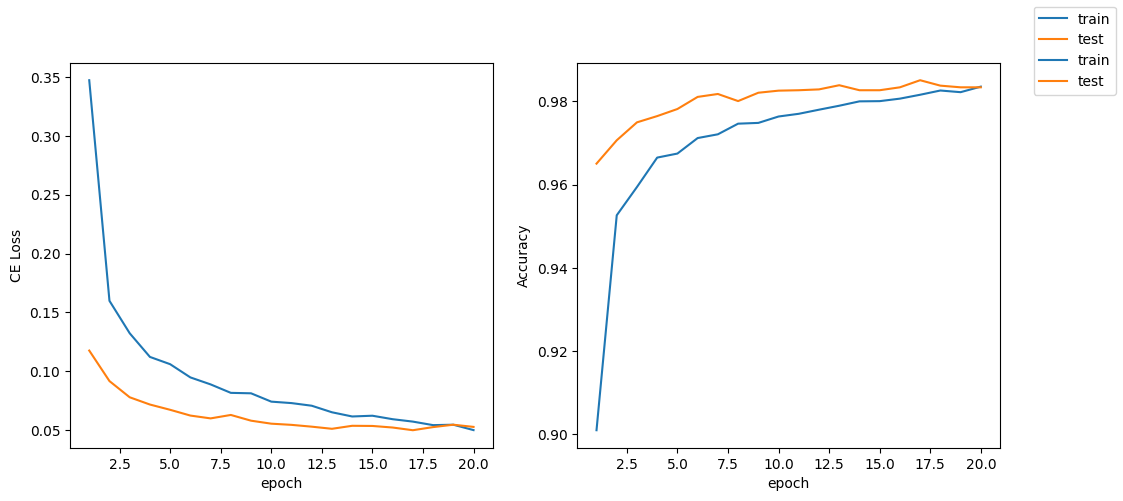

[0.9010249732905983, 0.9526408920940171, 0.9594350961538461, 0.9664963942307693, 0.9674646100427351, 0.9711872329059829, 0.9720886752136753, 0.9746427617521367, 0.9748263888888888, 0.9763621794871795, 0.9770132211538461, 0.9779981303418803, 0.9789496527777778, 0.9800013354700855, 0.9800514155982906, 0.9806523771367521, 0.9815872061965812, 0.9826055021367521, 0.9822048611111112, 0.9835403311965812] [0.9650440705128205, 0.9706530448717948, 0.9749599358974359, 0.9764623397435898, 0.9781650641025641, 0.9810697115384616, 0.9817708333333334, 0.9800681089743589, 0.9820713141025641, 0.9825721153846154, 0.9826722756410257, 0.9828725961538461, 0.9838741987179487, 0.9826722756410257, 0.9826722756410257, 0.9833733974358975, 0.9850761217948718, 0.9837740384615384, 0.9833733974358975, 0.9833733974358975]


In [ ]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion, n_epochs = 20)
print(train_acc, test_acc)

## Conv NN

In [100]:
N_CLASSES = 10
N_FEATS = 28
BATCH_SIZE = 250
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [101]:
elastic = transforms.ElasticTransform()

class RandomElastic(object):
    def __call__(self, tensor, p = 0.5):
        if torch.rand(1) < p:
            return elastic(tensor)
        else:
            return tensor

transform_train = transforms.Compose([
    transforms.ToTensor(),
    RandomElastic()
])
transform_test = transforms.ToTensor()

train_data = MNIST('/content', train = True, download = True, transform = transform_train)
test_data = MNIST('/content', train = False, transform = transform_test)
print(f"Train size: {train_data.__len__()}, test size: {test_data.__len__()}")

Train size: 60000, test size: 10000


In [102]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

In [99]:
class Conv(nn.Module):

    def __init__(
            self, in_dim = N_FEATS,
            out_dim = N_CLASSES,
            k_size = 5,
            p_size = 2,
            dropout = 0.4,
            hidden_chan = 24,
            out_chan = 24,
            hidden_dim = 1024
            ):
        super(Conv, self).__init__()

        self.in_dim = in_dim
        self.out_chan = out_chan
        self.conv1 = nn.Conv2d(1, hidden_chan, kernel_size = (k_size, k_size), padding = (p_size, p_size), padding_mode = 'reflect')
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan * 2, kernel_size = (k_size, k_size), padding = (p_size, p_size), padding_mode = 'reflect')
        self.conv3 = nn.Conv2d(hidden_chan * 2, hidden_chan, kernel_size = (k_size, k_size), padding = (p_size, p_size), padding_mode = 'reflect')
        self.conv4 = nn.Conv2d(hidden_chan, out_chan, kernel_size = (k_size, k_size), padding = (p_size, p_size), padding_mode = 'reflect')
        self.bn1 = nn.BatchNorm2d(hidden_chan)
        self.bn2 = nn.BatchNorm2d(hidden_chan * 2)
        self.bn3 = nn.BatchNorm2d(hidden_chan)
        self.bn4 = nn.BatchNorm2d(out_chan)
        self.fc1 = nn.Linear(out_chan * in_dim**2, out_dim)
        #self.fc2 = nn.Linear(hidden_dim, out_dim)
        #self.bn_fc = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        X = self.bn1(self.dropout(self.relu(self.conv1(X))))
        X = self.bn2(self.dropout(self.relu(self.conv2(X))))
        X = self.bn3(self.dropout(self.relu(self.conv3(X))))
        X = self.bn4(self.dropout(self.relu(self.conv4(X))))

        X = self.fc1(X.reshape(-1, self.out_chan * self.in_dim**2))
        #X = self.fc2(self.relu(self.bn_fc(self.dropout(X))))
        return X

In [103]:
model = Conv().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

epoch: 20
train loss: 0.02774432954271712, train accuracy: 0.9906667046248913
test loss: 0.01825819112227691, test accuracy: 0.9938000246882439


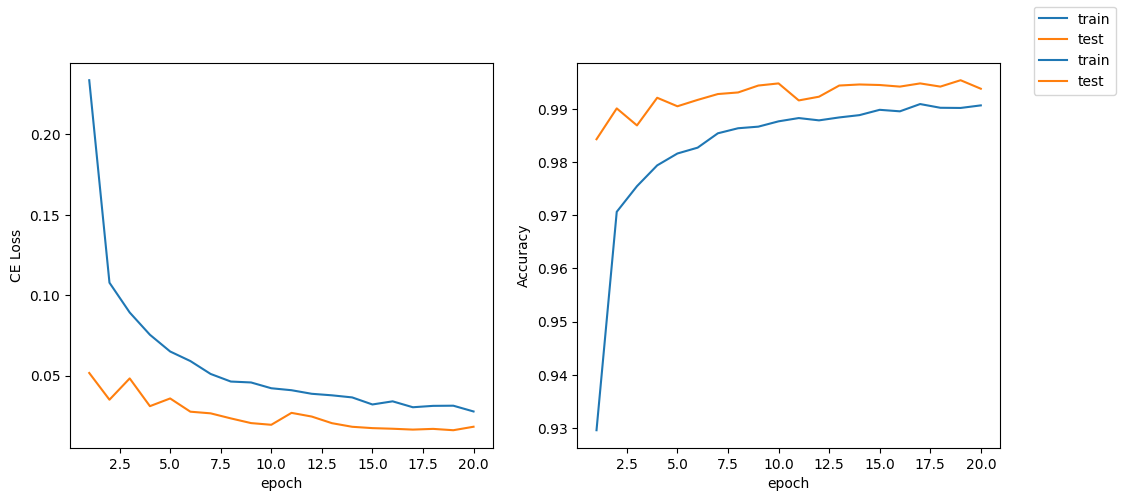

[0.9295667108769218, 0.9706500475605329, 0.9754667130609354, 0.9793833749989669, 0.9816167086362839, 0.9827167076369127, 0.9854167036712169, 0.9863667060931524, 0.9866667042175928, 0.9876667037606239, 0.9882833716770013, 0.9878500387072563, 0.9884000373383363, 0.9888333703080813, 0.9898333698511124, 0.9895500384271145, 0.9909167033930619, 0.9902167034645876, 0.9901833705604076, 0.9906667046248913] [0.9843000397086143, 0.9901000306010246, 0.9869000345468522, 0.9921000272035598, 0.9905000284314156, 0.9917000308632851, 0.9928000271320343, 0.9931000277400017, 0.994400030374527, 0.9948000252246857, 0.9916000291705132, 0.9923000290989876, 0.9944000229239464, 0.9946000307798386, 0.9945000261068344, 0.9942000284790993, 0.9948000267148018, 0.9942000299692154, 0.9954000234603881, 0.9938000246882439]


In [104]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion, n_epochs = 20)
print(train_acc, test_acc)

epoch: 20
train loss: 0.021790449606002463, train accuracy: 0.9932333675523599
test loss: 0.01524554916222769, test accuracy: 0.9948000207543373


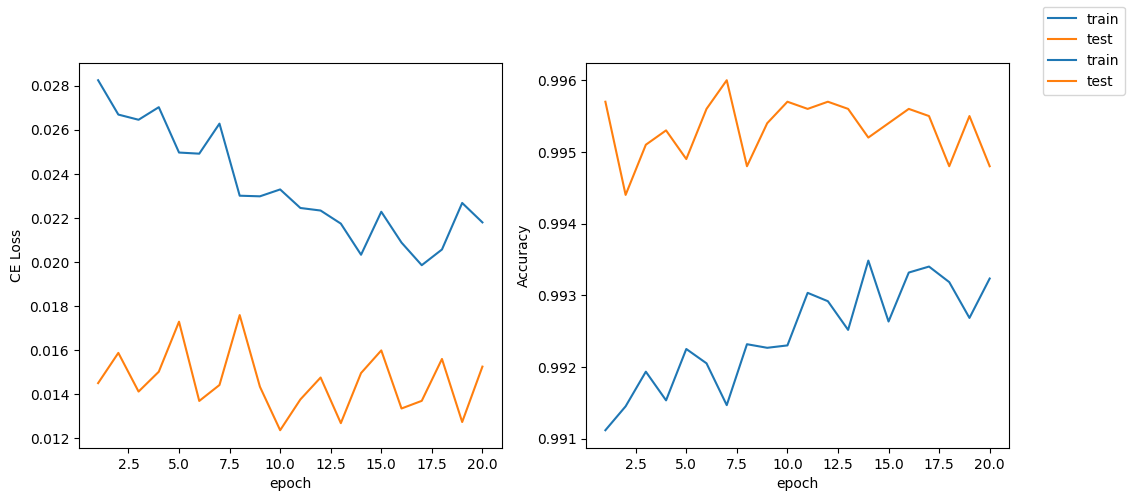

[0.9911167045434316, 0.9914500368138154, 0.9919333691398303, 0.991533371557792, 0.9922500369449456, 0.9920500372846921, 0.9914667047560215, 0.9923167027533054, 0.9922667031486829, 0.9923000355561574, 0.9930333683888117, 0.9929167022307713, 0.9925167034069697, 0.9934833673139413, 0.9926333715518315, 0.9933167015512784, 0.993400036295255, 0.9931833669543266, 0.9926833691696326, 0.9932333675523599] [0.9957000255584717, 0.9944000244140625, 0.995100024342537, 0.9953000262379647, 0.9949000284075737, 0.995600026845932, 0.9960000291466713, 0.9948000237345695, 0.9954000234603881, 0.9957000255584717, 0.9956000283360481, 0.9957000255584717, 0.995600026845932, 0.9952000245451927, 0.9954000264406204, 0.9956000253558159, 0.9955000266432762, 0.9948000282049179, 0.9955000221729279, 0.9948000207543373]


In [105]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion, n_epochs = 20)
print(train_acc, test_acc)

## RNN

In [ ]:
N_CLASSES = 10
N_FEATS = 28
BATCH_SIZE = 250
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
elastic = transforms.ElasticTransform()

class RandomElastic(object):
    def __call__(self, tensor, p = 0.5):
        if torch.rand(1) < p:
            return elastic(tensor)
        else:
            return tensor

transform_train = transforms.Compose([
    transforms.ToTensor(),
    #RandomElastic()
])
transform_test = transforms.ToTensor()

train_data = MNIST('/content', train = True, download = True, transform = transform_train)
test_data = MNIST('/content', train = False, transform = transform_test)
print(f"Train size: {train_data.__len__()}, test size: {test_data.__len__()}")

Train size: 60000, test size: 10000


In [ ]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
class RNN1(nn.Module):

    def __init__(self, in_dim = N_FEATS, out_dim = N_CLASSES, hidden_dim = 256, num_layers = 4, dropout = 0.5):
        super(RNN1, self).__init__()

        self.rnn = nn.GRU(in_dim, hidden_dim, batch_first = True, num_layers = num_layers, dropout = dropout, bidirectional = True)
        self.fc_out = nn.Linear(hidden_dim * 2, out_dim)

    def forward(self, X):
        X = X.squeeze(1)
        X, _ = self.rnn(X)
        X = self.fc_out(X.mean(1))

        return X

In [ ]:
model = RNN1().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

epoch: 20
train loss: 0.009922890262654012, train accuracy: 0.9969000260035197
test loss: 0.042670328335862, test accuracy: 0.9883000329136848


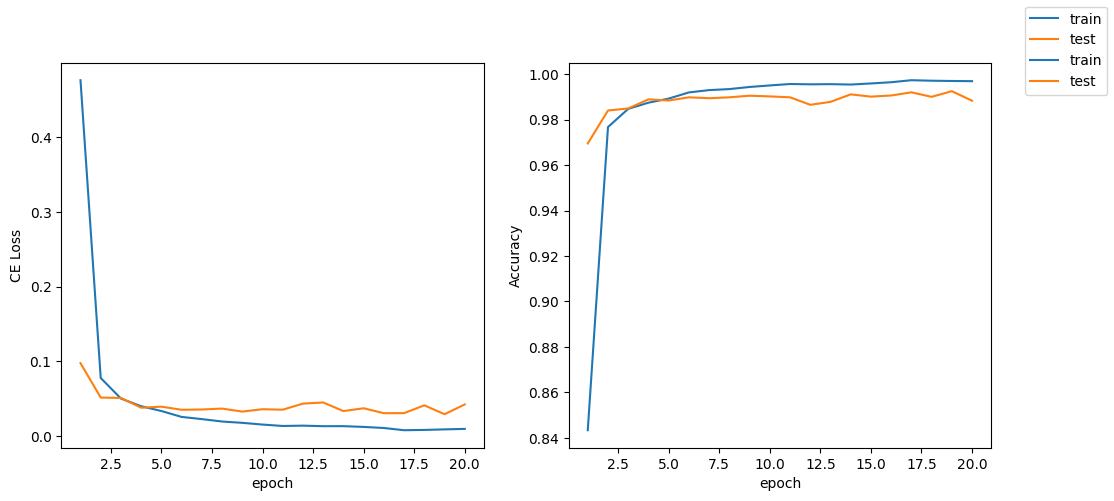

[0.843366706961145, 0.9767167093853156, 0.9847167062262694, 0.9874333729346593, 0.9892333701252938, 0.9919500378270943, 0.9929667038222154, 0.9934167012572288, 0.994350033501784, 0.9950166982909043, 0.9956500306725502, 0.9955166983107726, 0.9955833656092484, 0.995416697114706, 0.9959000289440155, 0.996433361619711, 0.9973166885475317, 0.9971000236769517, 0.9969833572705586, 0.9969000260035197] [0.969500045478344, 0.9840000331401825, 0.9849000334739685, 0.9889000311493874, 0.9884000301361084, 0.9898000329732894, 0.9894000321626664, 0.9898000299930573, 0.9905000314116478, 0.9902000293135643, 0.9898000314831734, 0.986500033736229, 0.9878000319004059, 0.991100026667118, 0.9901000335812569, 0.990600036084652, 0.9920000284910202, 0.9900000303983688, 0.9925000265240669, 0.9883000329136848]


In [ ]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion, n_epochs = 20)
print(train_acc, test_acc)

In [96]:
class RCNN(nn.Module):

    def __init__(self, in_dim = N_FEATS, out_dim = N_CLASSES, hidden_dim = 256, num_layers = 2, dropout = 0.5):
        super(RCNN, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim

        self.rnn1 = nn.GRU(in_dim, hidden_dim, batch_first = True, num_layers = num_layers, dropout = dropout, bidirectional = True)
        self.conv1 = nn.Conv2d(1, 1, kernel_size = (13, 13), padding = (6, 6), padding_mode = 'reflect')
        self.bn1 = nn.BatchNorm2d(1)
        self.rnn2 = nn.GRU(2 * hidden_dim, hidden_dim, batch_first = True, num_layers = num_layers, dropout = dropout, bidirectional = True)
        self.conv2 = nn.Conv2d(1, 1, kernel_size = (13, 13), padding = (6, 6), padding_mode = 'reflect')
        self.bn2 = nn.BatchNorm2d(1)
        self.rnn3 = nn.GRU(2 * hidden_dim, hidden_dim, batch_first = True, num_layers = num_layers, dropout = dropout, bidirectional = True)
        self.conv3 = nn.Conv2d(1, 1, kernel_size = (13, 13), padding = (6, 6), padding_mode = 'reflect')
        self.bn3 = nn.BatchNorm2d(1)
        self.fc_out = nn.Linear(2 * in_dim * hidden_dim, out_dim)

        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, X):
        X = X.squeeze(1)

        X, _ = self.rnn1(X)
        X = self.dropout(X.unsqueeze(1))
        X = self.bn1(self.dropout(self.gelu(self.conv1(X)))).squeeze(1)

        X, _ = self.rnn2(X)
        X = self.dropout(X.unsqueeze(1))
        X = self.bn2(self.dropout(self.gelu(self.conv2(X)))).squeeze(1)

        X, _ = self.rnn3(X)
        X = self.dropout(X.unsqueeze(1))
        X = self.bn3(self.dropout(self.gelu(self.conv3(X)))).squeeze(1)

        X = self.fc_out(X.reshape(-1, 2 * self.hidden_dim * self.in_dim))
        return X

In [97]:
model = RCNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

epoch: 20
train loss: 0.01807159874976302, train accuracy: 0.9944333667556445
test loss: 0.031946740067678545, test accuracy: 0.9917000293731689


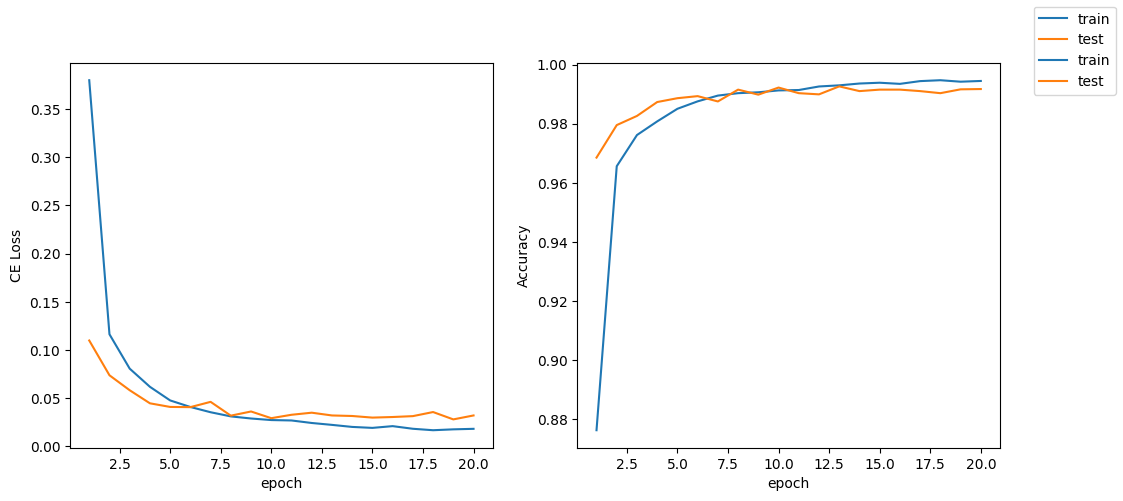

[0.8762500420212745, 0.9655833805600802, 0.9761333756148816, 0.9807500414550304, 0.9850167045990627, 0.9875333704054355, 0.989483368396759, 0.9903000362217427, 0.9906000373264153, 0.9912333702047665, 0.9913667015731334, 0.9925667027632396, 0.9929500363767148, 0.9935667018095652, 0.9938333665331205, 0.9934500339130561, 0.9943833678960801, 0.9946833662688732, 0.9941833669940631, 0.9944333667556445] [0.9685000360012055, 0.9795000344514847, 0.9826000392436981, 0.9873000338673592, 0.9886000350117683, 0.9893000274896622, 0.9875000327825546, 0.9915000319480896, 0.9898000329732894, 0.992200031876564, 0.9903000324964524, 0.9899000287055969, 0.9926000267267228, 0.9910000264644623, 0.9915000259876251, 0.9915000319480896, 0.9910000324249267, 0.9903000265359878, 0.9916000321507454, 0.9917000293731689]


In [98]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion, n_epochs = 20)
print(train_acc, test_acc)

# Fashion MNIST

In [106]:
N_CLASSES = 10
N_FEATS = 28
BATCH_SIZE = 250
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [107]:
elastic = transforms.ElasticTransform()

class RandomElastic(object):
    def __call__(self, tensor, p = 0.5):
        if torch.rand(1) < p:
            return elastic(tensor)
        else:
            return tensor

transform_train = transforms.Compose([
    transforms.ToTensor(),
    RandomElastic()
])
transform_test = transforms.ToTensor()

train_data = FashionMNIST('/content', train = True, download = True, transform = transform_train)
test_data = FashionMNIST('/content', train = False, transform = transform_test)
print(f"Train size: {train_data.__len__()}, test size: {test_data.__len__()}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.1MB/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.3MB/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw

Train size: 60000, test size: 10000


In [108]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

In [109]:
class Conv(nn.Module):

    def __init__(
            self, in_dim = N_FEATS,
            out_dim = N_CLASSES,
            k_size = 5,
            p_size = 2,
            dropout = 0.4,
            hidden_chan = 24,
            out_chan = 24,
            hidden_dim = 1024
            ):
        super(Conv, self).__init__()

        self.in_dim = in_dim
        self.out_chan = out_chan
        self.conv1 = nn.Conv2d(1, hidden_chan, kernel_size = (k_size, k_size), padding = (p_size, p_size), padding_mode = 'reflect')
        self.conv2 = nn.Conv2d(hidden_chan, hidden_chan * 2, kernel_size = (k_size, k_size), padding = (p_size, p_size), padding_mode = 'reflect')
        self.conv3 = nn.Conv2d(hidden_chan * 2, hidden_chan, kernel_size = (k_size, k_size), padding = (p_size, p_size), padding_mode = 'reflect')
        self.conv4 = nn.Conv2d(hidden_chan, out_chan, kernel_size = (k_size, k_size), padding = (p_size, p_size), padding_mode = 'reflect')
        self.bn1 = nn.BatchNorm2d(hidden_chan)
        self.bn2 = nn.BatchNorm2d(hidden_chan * 2)
        self.bn3 = nn.BatchNorm2d(hidden_chan)
        self.bn4 = nn.BatchNorm2d(out_chan)
        self.fc1 = nn.Linear(out_chan * in_dim**2, out_dim)
        #self.fc2 = nn.Linear(hidden_dim, out_dim)
        #self.bn_fc = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        X = self.bn1(self.dropout(self.relu(self.conv1(X))))
        X = self.bn2(self.dropout(self.relu(self.conv2(X))))
        X = self.bn3(self.dropout(self.relu(self.conv3(X))))
        X = self.bn4(self.dropout(self.relu(self.conv4(X))))

        X = self.fc1(X.reshape(-1, self.out_chan * self.in_dim**2))
        #X = self.fc2(self.relu(self.bn_fc(self.dropout(X))))
        return X


In [110]:
model = Conv().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

epoch: 40
train loss: 0.22505115469296774, train accuracy: 0.9170000438888868
test loss: 0.217319605499506, test accuracy: 0.9288000449538231


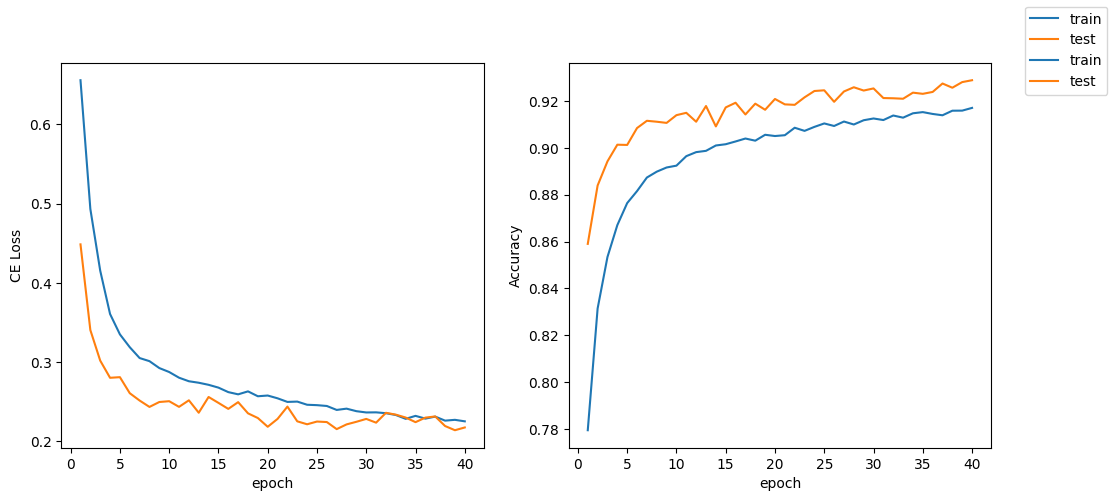

[0.7795333681007226, 0.8314500403900941, 0.8534167091051738, 0.8670000451306502, 0.876400043318669, 0.8815167101720969, 0.8873000430564085, 0.8898000424106915, 0.8915833778679371, 0.8923667095601558, 0.8964167108138402, 0.8981333769857883, 0.8986833766102791, 0.9009667110939821, 0.9015000427762667, 0.9026833770175775, 0.90393337632219, 0.9030167110264301, 0.9055333773295084, 0.9050000419219335, 0.9053500441213449, 0.908533375710249, 0.9072000434001287, 0.9089000428716342, 0.9103667092820008, 0.9092833764851094, 0.9111833781003952, 0.9099167108535766, 0.9117333754897118, 0.9124833767612776, 0.9118167087435722, 0.9137500430146853, 0.912833376477162, 0.9147000446915626, 0.9152000434696674, 0.9144167095422745, 0.9138500452041626, 0.9158000436921915, 0.9158333798249563, 0.9170000438888868] [0.8590000435709954, 0.8839000433683395, 0.8942000418901443, 0.9013000428676605, 0.9012000486254692, 0.9084000438451767, 0.9115000382065773, 0.9111000344157218, 0.9106000453233719, 0.9139000415802002, 0.9

In [111]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion, n_epochs = 40)
print(train_acc, test_acc)

epoch: 7
train loss: 0.21798819613953432, train accuracy: 0.9187667096654574
test loss: 0.20769224856048824, test accuracy: 0.9302000448107719


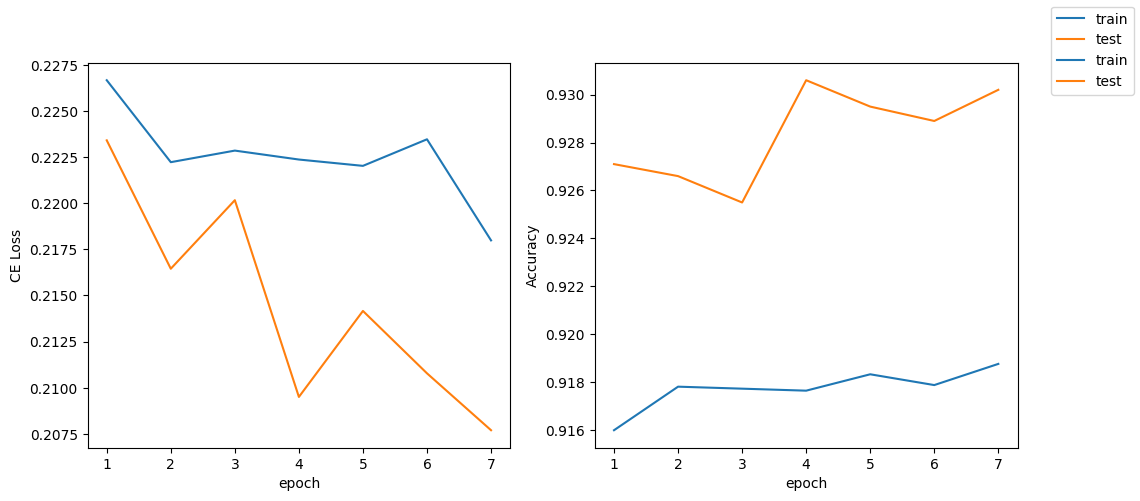

 69%|██████▉   | 166/240 [01:17<00:42,  1.75it/s]

In [ ]:
train_acc, test_acc = train(model, train_loader, test_loader, optimizer, criterion, n_epochs = 10)
print(train_acc, test_acc)